# Starbucks Data Exploration
## by Wei Xinyu


## Project Definition

### Project Overview
> This project uses simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

> Not all users receive the same offer, and that is the challenge to solve with this data set.

> The task of this project is to combine transaction, demographic and offer data to predict whether someone will respond to an offer. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

> Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

> The transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

> Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

#### Example
> To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

>However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem Statement
#### Question
> Predicts whether someone will respond to an offer or not ?

#### Solution Strategy
> First, assess and clean the data, then split the data into training and testing set. 

> Second, calculate the baseline scores with a model predicting true for all data.

> Third, try to train the three classifiers on the training data(1%, 10% and 100%): Decision Tree Classifier, Random Forest Classifier and AdaBoost Classifier. Then verify them on the testing data and find the best classifier.

> Forth, tune 3 hyperparameters of the best classifier and compare the scores with unoptimized model and baseline.

### Metrics
> This project will use the accuracy and F1 score as the metrics, because accuracy is the direct metric that shows how well a model classifies correctly, and F1 score is a balanced metric considering both the precision and recall, which is very helpful when the data is not balanced. 


## Analysis
### Data Sets Description

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Data Exploration and Visualization

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Import supplementary visualization code visuals.py
import visuals as vs
%matplotlib inline

Read in the data source into dataframe.

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Explore the general info:

In [3]:
# explore the portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


From the general view, we can need the following cleaning steps:
* One hot encode channels column
* One hot encode offer_type column 

In [5]:
# explore the profile info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile[profile.age == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

[]

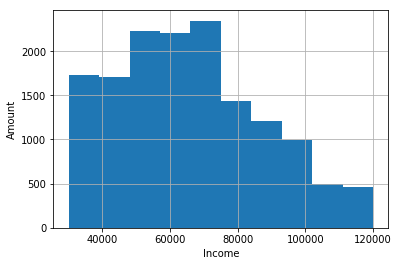

In [8]:
profile.income.hist()
plt.xlabel('Income')
plt.ylabel('Amount')
plt.plot()

[]

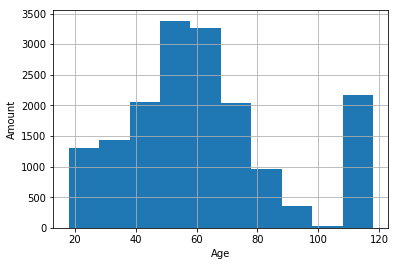

In [9]:
profile.age.hist()
plt.xlabel('Age')
plt.ylabel('Amount')
plt.plot()

From the general view of profile data, we can need the following cleaning steps:
* Deal with the NAN value in gender and income column
* Deal with 2175 abnormal data with age 118 
* One hot encode gender column
* Extract year that the customer became a member
* One hot encode the year that the customer became a member

In [10]:
# explore the transcript info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


We can only see one event in the first few lines, so we print statistics of events:

In [12]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are four events listed here, so we will further explore them:

[]

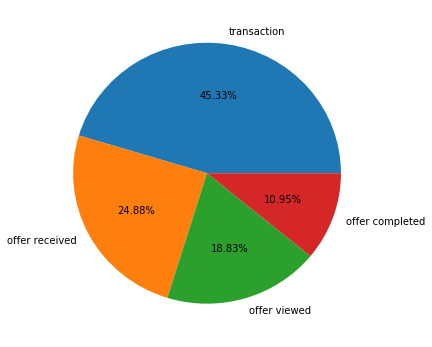

In [13]:
plt.figure(figsize = [6,6])
plt.pie(transcript.event.value_counts(),autopct='%.2f%%', labels = transcript.event.value_counts().index)
plt.plot()

In [14]:
transcript[transcript['event'] == 'offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [16]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [17]:
transcript[transcript['event'] == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


Then we explore the transcripts of one specific customer:

In [18]:
transcript[transcript['person'] =='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,event,person,time,value
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,{'amount': 21.55}
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,{'amount': 32.87}
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,{'amount': 19.99}
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,{'amount': 20.97}
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,{'amount': 31.09}
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


From this example, we can summarize the actions of a valid response to the offer:
    1. Receive a offer;
    2. View the offer in the valid duration;
    3. Complete the offer in the valid duration;
So we will use this process to give labels to whether someone responds to a offer or not.

Almost half of the data are transactions and they are not important to our analysis, so we need to split the data.

From the general view of transcript data, we can need the following cleaning steps:
* Extract values from dict in the value column
* Split the transcript by events
* Turn time column into days.The duration in portfolio is in days, and the time for each transcript is in hours, we need to make them in the same units.

## Methodology
### Data Preprocessing

#### Clean portfolio data

##### One hot encode channels column:

In [19]:
# transform channel columns from list to string
portfolio.loc[portfolio['channels'].notnull(), 'channels'] = portfolio.loc[portfolio['channels'].notnull(), 'channels'].apply(set).str.join(',')

In [20]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"social,email,mobile",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"mobile,social,email,web",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"mobile,email,web",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"mobile,email,web",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"email,web",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [21]:
# One hot encode with get_dummies and drop the original column
portfolio = pd.concat([portfolio.drop('channels', axis=1), portfolio['channels'].str.get_dummies(sep=",")], axis=1)

In [22]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


##### One hot encode offer_type column:

In [23]:
# One hot encode with get_dummies and drop the original column
portfolio = pd.concat([portfolio.drop('offer_type', axis=1), portfolio['offer_type'].str.get_dummies()], axis=1)

In [24]:
portfolio.head()

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


#### Clean profile data

##### Deal with the NAN value in gender and income column:

In [25]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [26]:
sum(profile.gender.isna() & profile.income.isna())

2175

In [27]:
sum(profile.gender.isna() | profile.income.isna())

2175

So gender and income are NAN at the same time, and these are important features for a customer. So we decide to remove these 2175 items.

In [28]:
profile.dropna(inplace=True)

In [29]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


There are no NAN now.

##### Deal with 2175 abnormal data with age 118:

In [30]:
profile[profile.age==118].count()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

This issue is also resolved by previous action.

##### Extract year that the customer became a member:

Transform the became_member_on column to a datetime object and extract year from it

In [31]:
# Transform the became_member_on column to a datetime object
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [32]:
# Extract year
profile['became_member_year'] = profile['became_member_on'].dt.year

##### One hot encode the year that the customer became a member:

In [33]:
# One hot encode with get_dummies and drop the original column
profile = pd.concat([profile.drop('became_member_year', axis=1), profile['became_member_year'].astype(str).str.get_dummies()], axis=1)

In [34]:
profile.drop(columns=['became_member_on'], inplace=True)

In [35]:
profile.head()

,age,gender,id,income,2013,2014,2015,2016,2017,2018
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0


##### One hot encode gender column:

In [36]:
# One hot encode with get_dummies and drop the original column
profile = pd.concat([profile.drop('gender', axis=1), profile['gender'].str.get_dummies()], axis=1)

In [37]:
profile.head()

,age,id,income,2013,2014,2015,2016,2017,2018,F,M,O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,1,0


In [5]:
#profile['age_bucket'] = (profile.age / 10).astype(int)

In [6]:
#profile['age_bucket'].unique()

array([ 7,  6,  5,  9,  4,  3,  2,  1,  8, 10])

In [7]:
#profile = pd.concat([profile.drop(columns = ['age', 'age_bucket'], axis=1), pd.get_dummies(profile['age_bucket'].astype(str), prefix='age')], axis=1)

In [8]:
#profile.head()

,person,offer_id,days,age,income,2013,2014,2015,2016,2017,...,age_1,age_10,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,100000.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,68,70000.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,65,53000.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,65,53000.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,56,88000.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
#profile['income_bucket'] = (profile.income / 10000).astype(int)

In [10]:
#profile['income_bucket'].unique()

array([10,  7,  5,  8,  4,  3,  9, 11,  6, 12])

In [11]:
#profile = pd.concat([profile.drop(columns = ['income', 'income_bucket'], axis=1), pd.get_dummies(profile['income_bucket'].astype(str), prefix='income')], axis=1)

#### Clean transcript data

##### Extract values from dict in the value column

In [38]:
# extract offer id and reward from transcript
offer_id_df=pd.DataFrame(transcript.value.tolist())
con_transcript = pd.concat((transcript,offer_id_df),axis=1)
con_transcript.drop(columns=['value'], inplace=True)

In [39]:
# Combine the offer_id and offer id
con_transcript.loc[con_transcript['offer_id'].isna(), 'offer_id'] = con_transcript.loc[con_transcript['offer_id'].isna(), 'offer id']
con_transcript.drop(columns=['offer id'], inplace=True)

In [40]:
con_transcript.head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


##### Drop the transcripts without customer profile data:

In [41]:
# whether the transcript has corresponding customer info
has_cumstomer_info = con_transcript['person'].isin(profile['id'])

In [42]:
# filter them out
con_transcript = con_transcript[has_cumstomer_info]

In [43]:
con_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 6 columns):
event       272762 non-null object
person      272762 non-null object
time        272762 non-null int64
amount      123957 non-null float64
offer_id    148805 non-null object
reward      32444 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.6+ MB


##### Turn time column into days:

In [44]:
# Turn hours into days
con_transcript['days'] = con_transcript['time'] / 24

In [45]:
# Drop the original column
con_transcript.drop(columns = ['time'], inplace=True)

##### Split the transcript by events:

In [46]:
offer_received = con_transcript[con_transcript['event'] == 'offer received']

In [47]:
offer_received.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 257886
Data columns (total 6 columns):
event       66501 non-null object
person      66501 non-null object
amount      0 non-null float64
offer_id    66501 non-null object
reward      0 non-null float64
days        66501 non-null float64
dtypes: float64(3), object(3)
memory usage: 3.6+ MB


In [48]:
offer_received.drop(columns=['event', 'amount', 'reward'], inplace=True)

In [49]:
offer_viewed = con_transcript[con_transcript['event'] == 'offer viewed']

In [50]:
offer_viewed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49860 entries, 12650 to 306507
Data columns (total 6 columns):
event       49860 non-null object
person      49860 non-null object
amount      0 non-null float64
offer_id    49860 non-null object
reward      0 non-null float64
days        49860 non-null float64
dtypes: float64(3), object(3)
memory usage: 2.7+ MB


In [51]:
offer_viewed.drop(columns=['event', 'amount', 'reward'], inplace=True)

In [52]:
con_transcript[con_transcript['event'] == 'offer completed'].head()

,event,person,amount,offer_id,reward,days
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,0.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,0.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,0.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,0.0


In [53]:
offer_completed = con_transcript[con_transcript['event'] == 'offer completed']

In [54]:
offer_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 12658 to 306527
Data columns (total 6 columns):
event       32444 non-null object
person      32444 non-null object
amount      0 non-null float64
offer_id    32444 non-null object
reward      32444 non-null float64
days        32444 non-null float64
dtypes: float64(3), object(3)
memory usage: 1.7+ MB


In [55]:
offer_completed.drop(columns=['event', 'amount'], inplace=True)

#### Build the integrated data

Then we can integrate all these dataframes and add one column ‘respond’ according to what we defined in the previous section:
*	Receive a offer;
*	View the offer in the valid duration;
*	Complete the offer in the valid duration;


In [56]:
def build_prediction_data(offer_received, offer_viewed, offer_completed, profile, portfolio):
    '''
    Use the source dataframe to integrate data and add labels
    
    INPUT
    offer_received - pandas dataframe, offer received transcript
    offer_viewed - pandas dataframe, offer viewed transcript
    offer_completed - pandas dataframe, offer_completed transcript
    profile - customer profile data
    portfolio - offer portfolio data

    OUTPUT
    df - pandas dataframe, integrated data with label 'respond'
    '''
    df = pd.merge(offer_received, profile, left_on='person', right_on='id', how='inner')
    df = pd.merge(df, portfolio, left_on='offer_id', right_on='id', how='inner')
    df.drop(columns=['id_x', 'id_y'], inplace=True)
    
    for i in range(df.shape[0]):
        offer_id = df.loc[i, 'offer_id']
        customer_id = df.loc[i, 'person']
        valid_start = df.loc[i, 'days']
        valid_end = df.loc[i, 'days'] + df.loc[i, 'duration']

        valid_viewed = offer_viewed[(offer_viewed['offer_id'] == offer_id) &
                                       (offer_viewed['person'] == customer_id) &
                                       (offer_viewed['days'] >= valid_start) &
                                       (offer_viewed['days'] <= valid_end)]

        valid_completed = offer_completed[(offer_completed['offer_id'] == offer_id) &
                                       (offer_completed['person'] == customer_id) &
                                       (offer_completed['days'] >= valid_start) &
                                       (offer_completed['days'] <= valid_end)]

        df.loc[i, 'respond'] = (valid_viewed.shape[0] and valid_completed.shape[0]) > 0
        
    df.to_pickle('df_clean_20230208.pickle')
    return df
    

In [57]:
df_clean_20230208 = build_prediction_data(offer_received, offer_viewed, offer_completed, profile, portfolio)

In [58]:
df_clean_20230208.head()

,person,offer_id,days,age,income,2013,2014,2015,2016,2017,...,duration,reward,email,mobile,social,web,bogo,discount,informational,respond
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,100000.0,0,0,0,0,1,...,7,5,1,1,0,1,1,0,0,True
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,68,70000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,True
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,65,53000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,False
3,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,65,53000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,True
4,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,56,88000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,False


In [4]:
df_clean = pd.read_pickle('df_clean_20230208.pickle')

In [5]:
df_clean.head()

,person,offer_id,days,age,income,2013,2014,2015,2016,2017,...,duration,reward,email,mobile,social,web,bogo,discount,informational,respond
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,100000.0,0,0,0,0,1,...,7,5,1,1,0,1,1,0,0,True
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,68,70000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,True
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,65,53000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,False
3,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,65,53000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,True
4,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,56,88000.0,0,0,0,0,0,...,7,5,1,1,0,1,1,0,0,False


In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 25 columns):
person           66501 non-null object
offer_id         66501 non-null object
days             66501 non-null float64
age              66501 non-null int64
income           66501 non-null float64
2013             66501 non-null int64
2014             66501 non-null int64
2015             66501 non-null int64
2016             66501 non-null int64
2017             66501 non-null int64
2018             66501 non-null int64
F                66501 non-null int64
M                66501 non-null int64
O                66501 non-null int64
difficulty       66501 non-null int64
duration         66501 non-null int64
reward           66501 non-null int64
email            66501 non-null int64
mobile           66501 non-null int64
social           66501 non-null int64
web              66501 non-null int64
bogo             66501 non-null int64
discount         66501 non-null int64
information

#### Feature engineering

Drop the columns that are not important to our problem, so we remove the offer_id, person, days columns.

In [7]:
features = df_clean.drop(columns=['offer_id','person', 'days'])

In [8]:
labels = features['respond']

In [9]:
labels.value_counts()

False    39636
True     26865
Name: respond, dtype: int64

In [10]:
features = features.drop(columns=['respond'])

Then we perform MinMax scaling on numerical features and normalization ensures that each feature is treated equally when applying supervised learners. 

In [11]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['income', 'age', 'difficulty', 'duration', 'reward']

features_minmax_transform = pd.DataFrame(data = features)
features_minmax_transform[numerical] = scaler.fit_transform(features[numerical])

# Show an example of a record with scaling applied
display(features_minmax_transform.head(n = 5))

,age,income,2013,2014,2015,2016,2017,2018,F,M,...,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,0.686747,0.777778,0,0,0,0,1,0,1,0,...,0.25,0.571429,0.5,1,1,0,1,1,0,0
1,0.602410,0.444444,0,0,0,0,0,1,0,1,...,0.25,0.571429,0.5,1,1,0,1,1,0,0
2,0.566265,0.255556,0,0,0,0,0,1,0,1,...,0.25,0.571429,0.5,1,1,0,1,1,0,0
3,0.566265,0.255556,0,0,0,0,0,1,0,1,...,0.25,0.571429,0.5,1,1,0,1,1,0,0
4,0.457831,0.644444,0,0,0,0,0,1,1,0,...,0.25,0.571429,0.5,1,1,0,1,1,0,0


### Implementation
#### Split training and testing data
Here we will split the data into training and testing set with the 7/3.

In [12]:
# Split the 'features' and 'labels' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_minmax_transform, 
                                                    labels, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [13]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 46550 samples.
Testing set has 19951 samples.


#### Fit and Validate the model
Here we choose to use a model that always respond to an offer as the control group, and compare with the accuracy and F-score of it as the baseline.

In [14]:
# Calculate the baseline score
base_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
base_f1_score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (base_accuracy))
print("Naive predictor f1-score: %.3f" % (base_f1_score))

Naive predictor accuracy: 0.404
Naive predictor f1-score: 0.576


Then we try three classification models on our dataset. Here we choose Decision Tree, Random Forest, and AdaBoost because they all have their own advantages:
* Decision Tree is easy to build model, explain the rules, and visualize the results.With the decision tree, It is easy to explain the logic and our dataset is not complicated.
* Random forest can classify data with huge amount of features without dimension reduction.It can help justify the importance of features. 
* Adaboost is a classifier with high precision. It is easy to understand the model and not easy to overfit.

We will train these three models on 1% 10% and 100% of the training data, and then verify the performance on training and testing dataset with accuracy and f1 score. The training time is also recorded for reference. Here I use some template and demo code from the Introduction to Machine Learning of Pytorch Program

In [15]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    INPUTS:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
       
    OUTPUTS:
       - result: time, accuracy and f1 scores on training and testing datasets
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first sample_size training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:sample_size], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F1-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = f1_score(y_train[:sample_size], predictions_train)
        
    # Compute F1-score on the test set which is y_test
    results['f_test'] = f1_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

DecisionTreeClassifier trained on 465 samples.
DecisionTreeClassifier trained on 4655 samples.
DecisionTreeClassifier trained on 46550 samples.
RandomForestClassifier trained on 465 samples.
RandomForestClassifier trained on 4655 samples.
RandomForestClassifier trained on 46550 samples.
AdaBoostClassifier trained on 465 samples.
AdaBoostClassifier trained on 4655 samples.
AdaBoostClassifier trained on 46550 samples.


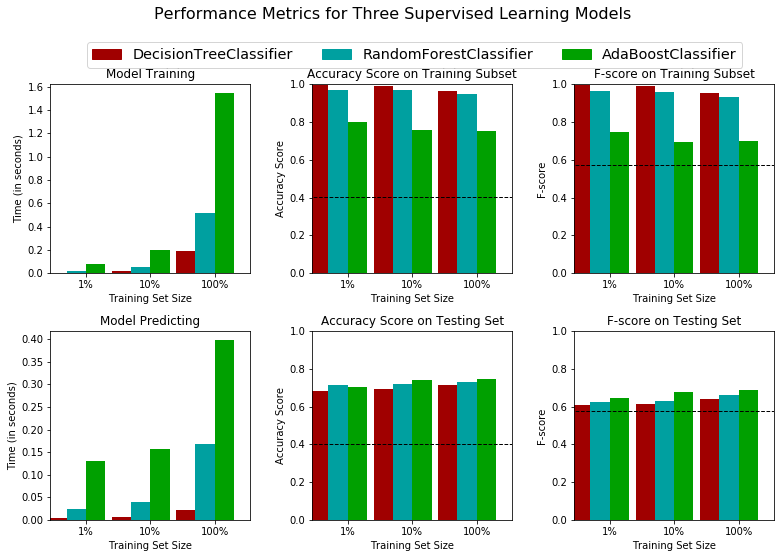

In [16]:
# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, base_accuracy, base_f1_score)

In [17]:
print(results)

{'DecisionTreeClassifier': {0: {'train_time': 0.0034410953521728516, 'pred_time': 0.004453182220458984, 'acc_train': 0.99784946236559136, 'acc_test': 0.68066763570748334, 'f_train': 0.99724517906336085, 'f_test': 0.60612055641421947}, 1: {'train_time': 0.016538381576538086, 'pred_time': 0.005274295806884766, 'acc_train': 0.99398496240601508, 'acc_test': 0.69064207307904368, 'f_train': 0.99236224768139669, 'f_test': 0.61400875547217015}, 2: {'train_time': 0.1898941993713379, 'pred_time': 0.021697998046875, 'acc_train': 0.96259935553168641, 'acc_test': 0.71465089469199539, 'f_train': 0.95193926846100774, 'f_test': 0.63988867101018398}}, 'RandomForestClassifier': {0: {'train_time': 0.01720428466796875, 'pred_time': 0.02351069450378418, 'acc_train': 0.97204301075268817, 'acc_test': 0.71134278983509602, 'f_train': 0.96358543417366949, 'f_test': 0.62440487836692105}, 1: {'train_time': 0.051473140716552734, 'pred_time': 0.039342641830444336, 'acc_train': 0.97035445757250272, 'acc_test': 0.719

### Refinement

From the plot and result above, we can find that all three models work better than the baseline. Among them three, when adaboost classifier on the whole training set, both the accuracy(0.748) and f1 scores(0.690) of the test result are the best. So we will choose the adaboost classifier for the next section. 
To further improve the classifier, we will use grid search with 2 hyper parameters tuned on the whole training set and find the best parameters.

## Results
### Model Evaluation and Justification

In this section, we will tune the hyperparameters of adaboost classifier with grid search (`GridSearchCV`), tunning on three parameters, learning_rate, n_estimators and algorithm.

In [20]:
# Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# Create the parameters list to tune, using a dictionary if needed.
parameters = {'learning_rate': [1, 0.1, 0.01], 'n_estimators': [50, 100, 150, 200, 250, 300], 'algorithm': ['SAMME', 'SAMME.R']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.3f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.3f}".format(f1_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.3f}".format(accuracy_score(y_test, best_predictions)))
print("Final F1-score on the testing data: {:.3f}".format(f1_score(y_test, best_predictions)))

Unoptimized model
------
Accuracy score on testing data: 0.748
F-score on testing data: 0.690

Optimized Model
------
Final accuracy score on the testing data: 0.748
Final F1-score on the testing data: 0.692


In [21]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=250, random_state=0)

The final scores comparison is as below:

|     Metric     | Unoptimized Model | Optimized Model | Baseline |
| :------------: | :---------------: | :-------------: |  :-----: |
| Accuracy Score |    0.748          |   0.748        |   0.404   |
| F1-score        |    0.690          |   0.692        |   0.576  |

* The optimized model's accuracy and F-score on the testing data are: 0.748 and 0.692.
* The F1 score is a little better than the unoptimized model and both F1 score and accuracy are far better than the baseline scores.

## Conclusion
### Reflection

The problem to solve in this project is to predict whether someone will respond to an offer or not? Four steps are followed to complete it:
> First, assess and clean the data, then split the data into training and testing set.

> Second, calculate the baseline scores with a model predicting true for all data, and get accuracy 0.404 and f1 score 0.576.

> Third, try to train the three classifiers on the training data(1%, 10% and 100%): Decision Tree Classifier, Random Forest Classifier and AdaBoost Classifier. Then verify them on the testing data and find out that the adaboost classifier is the best model.

> Forth, tune 3 hyperparameters of the adaboost classifier and compare the scores with unoptimized model and baseline. 


In [21]:
model = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.1, n_estimators=250, random_state=0)
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=250, random_state=0)

Then we use the feature_importances_ attribute to rank the importance of each feature:

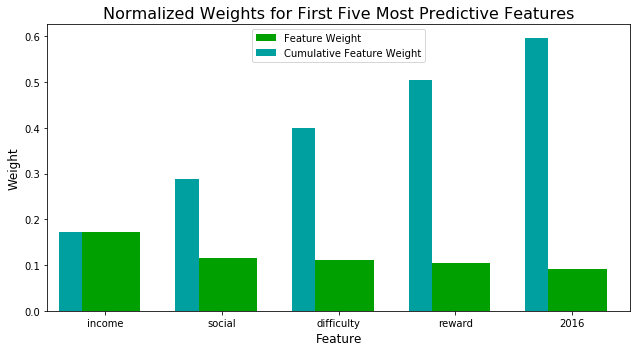

In [22]:
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [26]:
importances

array([ 0.048,  0.172,  0.   ,  0.   ,  0.072,  0.092,  0.   ,  0.064,
        0.   ,  0.056,  0.028,  0.112,  0.088,  0.104,  0.   ,  0.04 ,
        0.116,  0.   ,  0.   ,  0.   ,  0.008])

In [25]:
X_train.columns

Index(['age', 'income', '2013', '2014', '2015', '2016', '2017', '2018', 'F',
       'M', 'O', 'difficulty', 'duration', 'reward', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object')

From the above plot and statistics, we can illustrate that the income is the most important feature for predicting whether someone will respond to an offer or not.
Then all the second, third, forth are the properties of offer.
It's quite interesting that Age and Gender are not important features for this prediction. 

### Improvement

From the above section, we can find that serveral features contributes nearly no importance to the prediction, we can remove them.
I suppose the potential solution result scores may be a little worse than the current model, but not too much. This can greatly reduce the training time.

Other classfication models such as GradientBoostingClassifier, SGDClassifier, KNeighborsClassifier can also be tried on this data set.
The result may be a little higher or lower than the current model, but not too much.